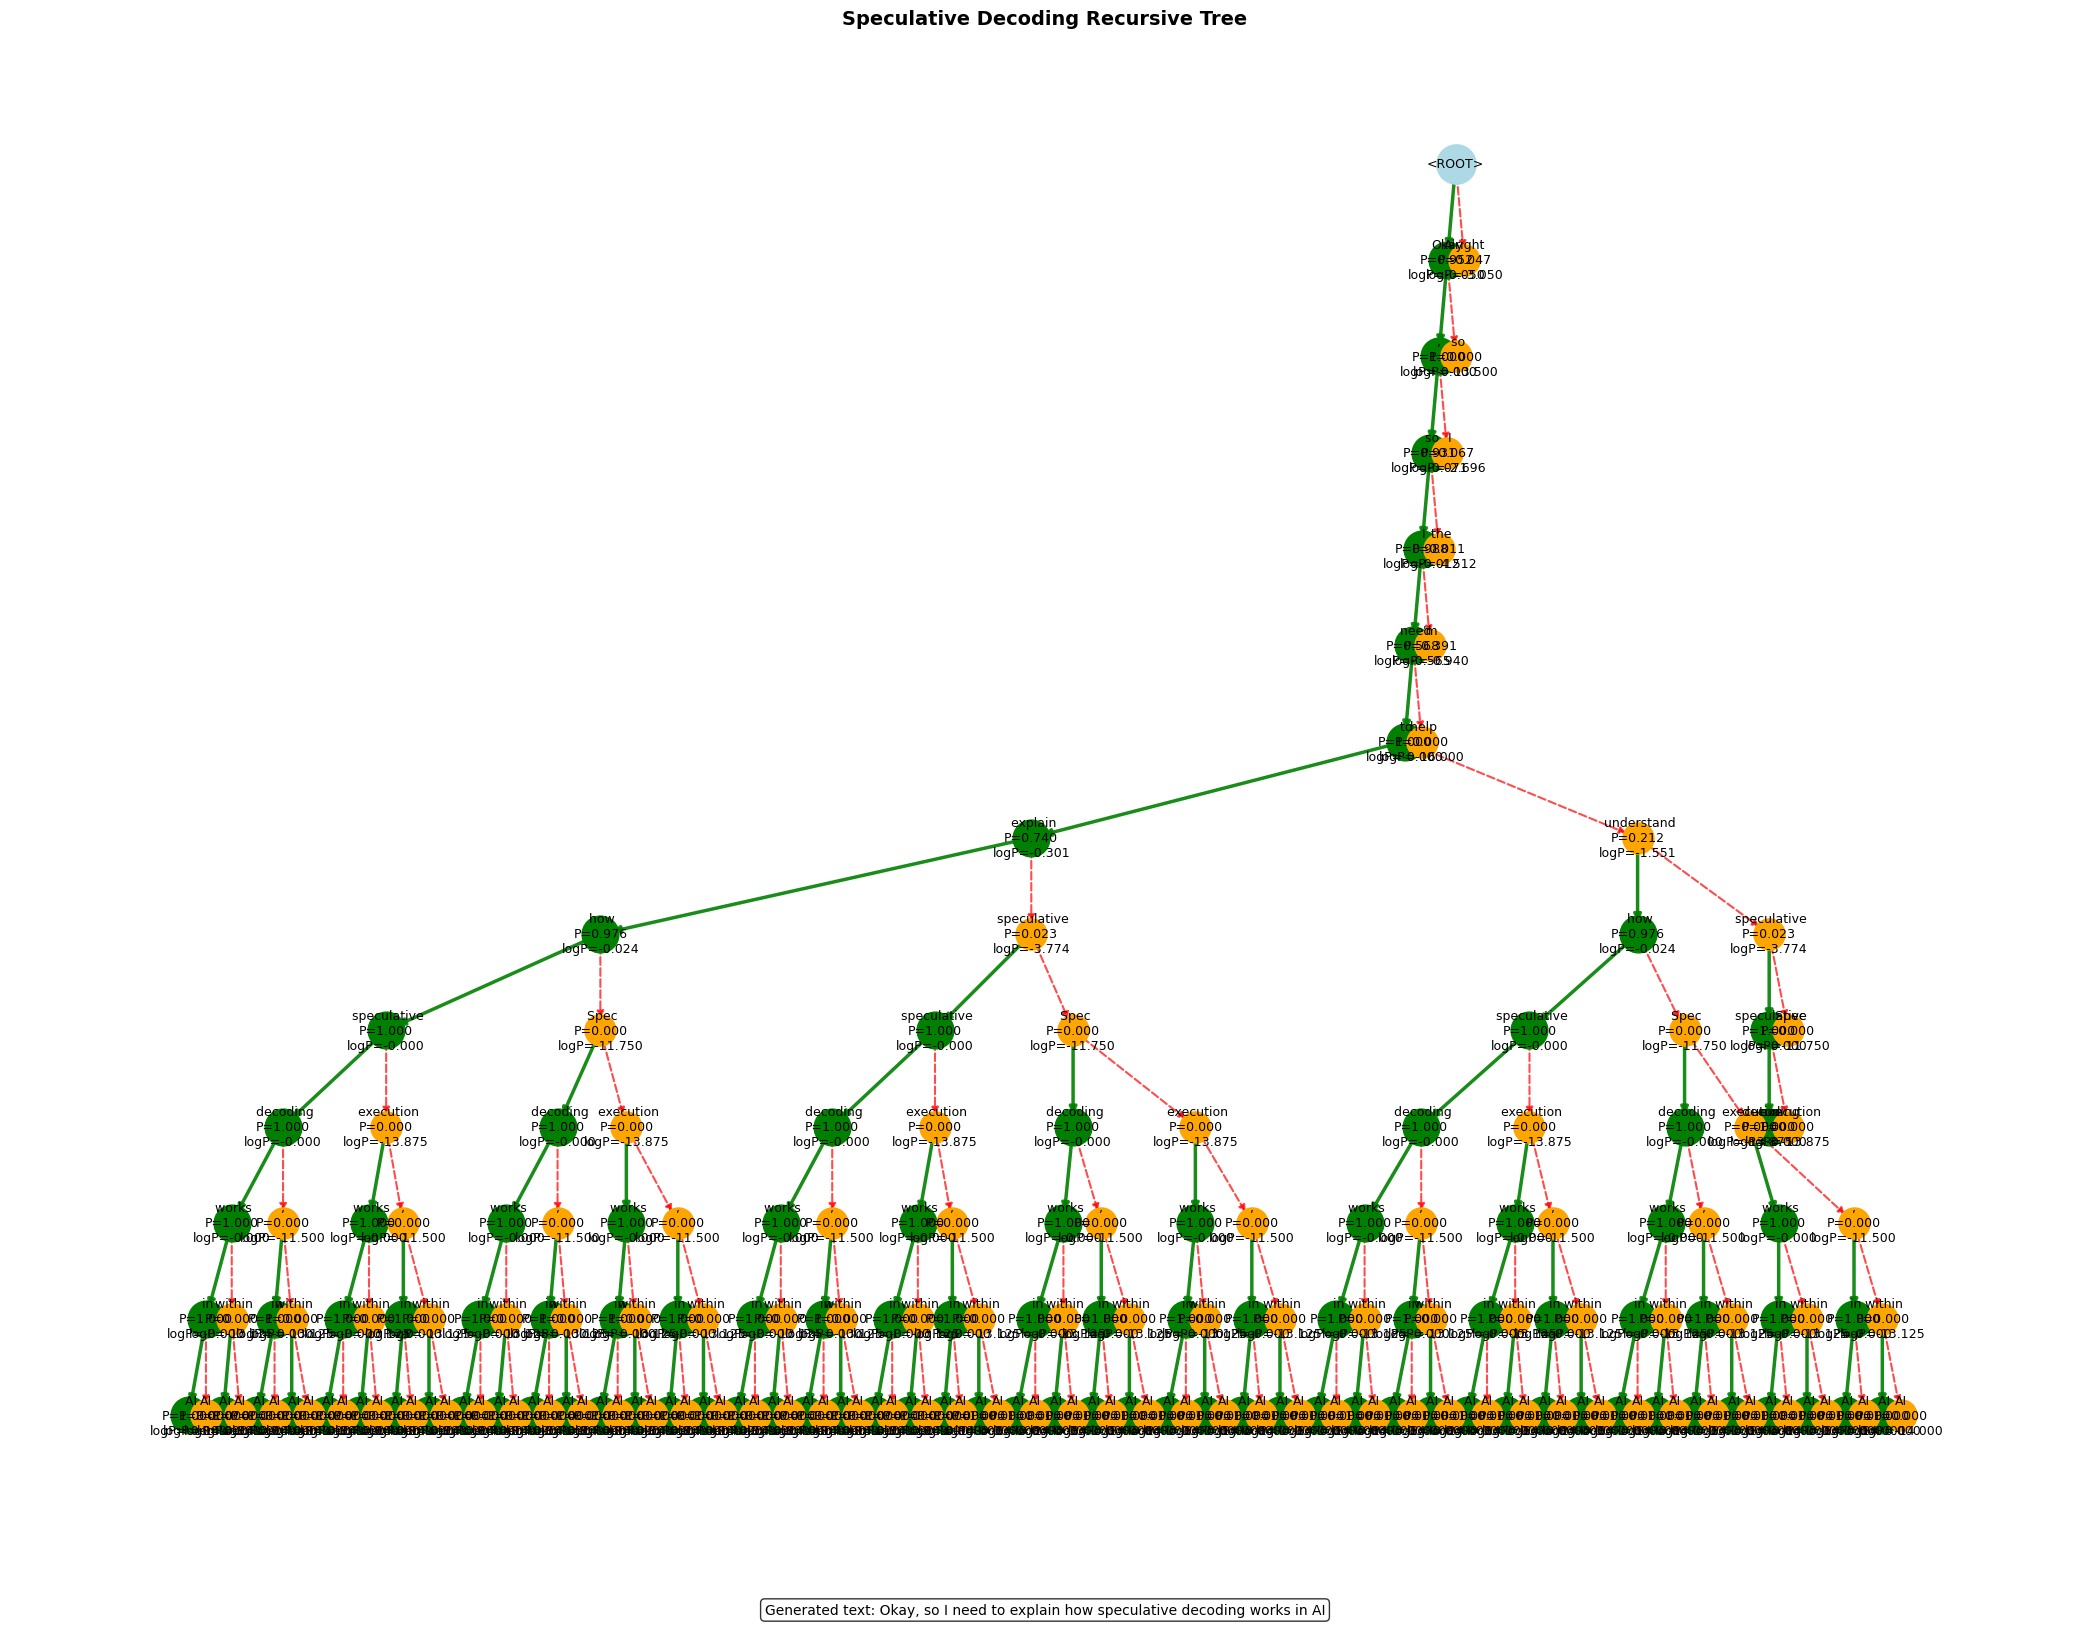


Best branch (cumulative log probability = -1.0228):
ROOT -> node_1 -> node_2 -> node_3 -> node_4 -> node_5 -> node_6 -> node_7 -> node_8 -> node_9 -> node_10 -> node_11 -> node_12 -> node_13

Full generated text from best branch:
Okay, so I need to explain how speculative decoding works in AI

Generation time: 2.12 seconds

Tree visualization saved as 'speculative_tree_recursive.png'

----- Logprobs Information -----
node_1: 'Okay', Prob=0.9516, LogP=-0.04963977634906769, ✓ ACCEPTED
node_10: ' decoding', Prob=1.0000, LogP=-2.0265558760002023e-06, ✓ ACCEPTED
node_100: ' within', Prob=0.0000, LogP=-13.125005722045898, ✗ REJECTED
node_101: ' AI', Prob=1.0000, LogP=-1.4305104514278355e-06, ✓ ACCEPTED
node_102: 'AI', Prob=0.0000, LogP=-14.000000953674316, ✗ REJECTED
node_103: ' Spec', Prob=0.0000, LogP=-11.75001049041748, ✗ REJECTED
node_104: ' decoding', Prob=1.0000, LogP=-2.0265558760002023e-06, ✓ ACCEPTED
node_105: ' works', Prob=1.0000, LogP=-1.8358061424805783e-05, ✓ ACCEPTED
node_106

<Figure size 4000x1200 with 0 Axes>

In [ ]:
import time
import traceback
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from openai import OpenAI

# Try to import graphviz_layout from nx_pydot; fallback if unavailable.
try:
    from networkx.drawing.nx_pydot import graphviz_layout
    def get_base_layout(G):
        return graphviz_layout(G, prog='dot')
    print("Using graphviz_layout from nx_pydot as base layout.")
except ImportError:
    def get_base_layout(G):
        return nx.spring_layout(G, seed=42, k=0.2)
    print("Using spring_layout as base layout.")

###############################################################################
# Custom layout: Use the base layout but add a small random horizontal offset.
###############################################################################
def compute_layout(G):
    base_pos = get_base_layout(G)
    levels = {}
    for node, data in G.nodes(data=True):
        d = data.get('depth', 0)
        levels.setdefault(d, []).append(node)
    max_depth = max(levels.keys()) if levels else 0
    new_pos = {}
    for d, nodes in levels.items():
        for node in nodes:
            base_x = base_pos[node][0]
            offset = random.uniform(-0.05, 0.05)
            x = base_x + offset
            y = 1 - (d/(max_depth+10))*0.3
            new_pos[node] = (x, y)
    return new_pos

###############################################################################
# Pruning: Randomly prune nodes at levels exceeding max_nodes_per_level.
###############################################################################
def get_subtree_nodes(tree, root):
    nodes = []
    stack = [root]
    while stack:
        cur = stack.pop()
        nodes.append(cur)
        stack.extend(list(tree.G.successors(cur)))
    return nodes

def prune_tree(tree, max_nodes_per_level=25):
    levels = {}
    for node, data in list(tree.G.nodes(data=True)):
        d = data.get('depth', 0)
        levels.setdefault(d, []).append(node)
    for d, nodes in levels.items():
        if d == 0:
            continue
        nodes = [n for n in nodes if n in tree.G]
        if len(nodes) > max_nodes_per_level:
            keep = random.sample(nodes, max_nodes_per_level)
            remove = [n for n in nodes if n not in keep]
            for node in remove:
                subtree = get_subtree_nodes(tree, node)
                for n in subtree:
                    if n in tree.G:
                        tree.G.remove_node(n)
            print(f"Pruned level {d}: kept {len(keep)} nodes, removed {len(remove)} nodes.")

###############################################################################
# Initialize OpenAI client.
###############################################################################
client = OpenAI(
    base_url="https://api--openai-vllm--d8zwcx9rqzwl.code.run/v1",
    api_key="EMPTY",
    timeout=60.0
)
target_model = "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"
draft_model = "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B"

###############################################################################
# HierarchicalTree: Stores candidate token nodes.
###############################################################################
class HierarchicalTree:
    def __init__(self):
        self.G = nx.DiGraph()
        self.G.add_node("ROOT", token="<ROOT>", prob=1.0, depth=0, logprob=0)
        self.next_id = 1
        self.logprobs_info = {}
    
    def add_child(self, parent, token, prob=0.0, accepted=False, logprob=None):
        node_id = f"node_{self.next_id}"
        self.next_id += 1
        parent_depth = self.G.nodes[parent].get('depth', 0)
        depth = parent_depth + 1
        self.G.add_node(node_id, token=token, prob=prob, accepted=accepted, depth=depth, logprob=logprob)
        self.G.add_edge(parent, node_id)
        if logprob is not None:
            self.logprobs_info[node_id] = logprob
        return node_id

###############################################################################
# Visualization: Draw the tree using the dynamic layout.
###############################################################################
def visualize_speculative_tree(tree):
    pos = compute_layout(tree.G)
    depths = [data.get('depth', 0) for _, data in tree.G.nodes(data=True)]
    max_depth = max(depths) if depths else 0
    total_nodes = len(tree.G.nodes())
    fig_width = max(16, (max_depth + 1) * 1.5)
    fig_height = max(10, total_nodes / 12)
    plt.figure(figsize=(fig_width, fig_height))
    
    accepted_edges = [(u, v) for u, v in tree.G.edges() if tree.G.nodes[v].get('accepted', False)]
    rejected_edges = [(u, v) for u, v in tree.G.edges() if not tree.G.nodes[v].get('accepted', False)]
    
    root_node = ["ROOT"]
    accepted_nodes = [node for node in tree.G.nodes() if node != "ROOT" and tree.G.nodes[node].get('accepted', False)]
    rejected_nodes = [node for node in tree.G.nodes() if node != "ROOT" and not tree.G.nodes[node].get('accepted', False)]
    
    nx.draw_networkx_edges(tree.G, pos, edgelist=accepted_edges, edge_color='green', width=2.5, alpha=0.9)
    nx.draw_networkx_edges(tree.G, pos, edgelist=rejected_edges, edge_color='red', style='dashed', width=1.5, alpha=0.7)
    nx.draw_networkx_nodes(tree.G, pos, nodelist=root_node, node_color='lightblue', node_size=800)
    nx.draw_networkx_nodes(tree.G, pos, nodelist=accepted_nodes, node_color='green', node_size=700)
    nx.draw_networkx_nodes(tree.G, pos, nodelist=rejected_nodes, node_color='orange', node_size=500)
    
    labels = {}
    for node in tree.G.nodes():
        data = tree.G.nodes[node]
        token = data['token']
        prob = data.get('prob', 0.0)
        logprob = data.get('logprob', None)
        if isinstance(token, str):
            token_str = token.replace('\n', '\\n').replace('\t', '\\t')
            if len(token_str) > 30:
                token_str = token_str[:27] + "..."
        else:
            token_str = str(token)
        if node == "ROOT":
            labels[node] = "<ROOT>"
        else:
            if logprob is not None:
                labels[node] = f"{token_str}\nP={prob:.3f}\nlogP={logprob:.3f}"
            else:
                labels[node] = f"{token_str}\nP={prob:.3f}"
    nx.draw_networkx_labels(tree.G, pos, labels=labels, font_size=9, font_color='black')
    
    accepted_path = []
    curr = "ROOT"
    while True:
        children = list(tree.G.successors(curr))
        accepted_children = [child for child in children if tree.G.nodes[child].get('accepted', False)]
        if not accepted_children:
            break
        curr = accepted_children[0]
        accepted_path.append(curr)
    accepted_text = "".join([tree.G.nodes[n]['token'] for n in accepted_path])
    
    plt.figtext(0.5, 0.02, f"Generated text: {accepted_text}",
                ha='center', fontsize=10,
                bbox={"boxstyle": "round", "fc": "white", "alpha": 0.8})
    plt.title("Speculative Decoding Recursive Tree", fontsize=14, weight='bold')
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    return plt.gcf()

###############################################################################
# Utility: Print log probabilities for all nodes.
###############################################################################
def print_logprobs(tree):
    print("\n----- Logprobs Information -----")
    for node in sorted(tree.G.nodes()):
        if node == "ROOT":
            continue
        data = tree.G.nodes[node]
        token = data['token']
        prob = data.get('prob', 0.0)
        accepted = data.get('accepted', False)
        logprob = data.get('logprob', "N/A")
        status = "✓ ACCEPTED" if accepted else "✗ REJECTED"
        print(f"{node}: '{token}', Prob={prob:.4f}, LogP={logprob}, {status}")
    print("-------------------------------\n")

###############################################################################
# Recursively choose the best branch based on cumulative log probability.
###############################################################################
def best_branch(tree, node):
    children = list(tree.G.successors(node))
    if not children:
        return tree.G.nodes[node].get('logprob', 0), [node]
    best_score = float('-inf')
    best_path = []
    node_logprob = tree.G.nodes[node].get('logprob', 0) if node != "ROOT" else 0
    for child in children:
        child_score, child_path = best_branch(tree, child)
        total_score = node_logprob + child_score
        if total_score > best_score:
            best_score = total_score
            best_path = [node] + child_path
    return best_score, best_path

###############################################################################
# Build the full tree recursively using token logprobs.
# For each token position, expand the current node with the top 2 candidates.
# Stop expansion if total nodes exceed max_total_nodes or if runtime exceeds max_time.
###############################################################################
def enhanced_speculative_decode(prompt, max_tokens=10, max_nodes_per_level=25,
                                max_total_nodes=200, max_time=10):
    print(f"Prompt: {prompt}")
    print("\nGenerating recursive speculative decoding tree...")
    
    tree = HierarchicalTree()
    extra_body = {"speculative_model": draft_model}
    start_time = time.time()
    
    print("Getting initial logprobs...")
    initial_completion = client.chat.completions.create(
        model=target_model,
        stream=False,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
        max_tokens=max_tokens,
        logprobs=True,
        top_logprobs=10,
        extra_body=extra_body
    )
    token_logprobs = []
    if hasattr(initial_completion.choices[0], 'logprobs') and initial_completion.choices[0].logprobs:
        print("\nLogprobs found in non-streaming response!")
        for idx, token_info in enumerate(initial_completion.choices[0].logprobs.content):
            token = token_info.token
            top_logprobs = token_info.top_logprobs
            token_logprobs.append((token, top_logprobs))
            print(f"Position {idx}, token: '{token}'")
            for lp in top_logprobs[:2]:
                print(f"   - alt '{lp.token}': logP={lp.logprob:.4f}")
            print()
    else:
        print("\nNo logprobs found; simulating alternatives.")
        for i in range(max_tokens):
            token_logprobs.append(("?", [type("LogProb", (), {"token": "?", "logprob": -0.1})() for _ in range(2)]))
    
    # Recursive function to expand the tree.
    def build_tree(node, pos):
        # Stop if we've reached maximum tokens.
        if pos >= min(max_tokens, len(token_logprobs)):
            return
        # Stop if runtime exceeds limit.
        if time.time() - start_time > max_time:
            return
        # Stop if total nodes exceed threshold.
        if tree.G.number_of_nodes() > max_total_nodes:
            return
        current_depth = tree.G.nodes[node].get('depth', 0)
        next_level_nodes = [n for n, data in tree.G.nodes(data=True) if data.get('depth', 0) == current_depth + 1]
        if len(next_level_nodes) >= max_nodes_per_level:
            return
        _, top_logprobs_list = token_logprobs[pos]
        sorted_tokens = sorted([(lp.token, lp.logprob) for lp in top_logprobs_list],
                                 key=lambda x: x[1], reverse=True)
        for cand_token, cand_logprob in sorted_tokens[:2]:
            prob_val = np.exp(cand_logprob)
            accepted_flag = (cand_token == sorted_tokens[0][0])
            child = tree.add_child(node, cand_token, prob=prob_val, accepted=accepted_flag, logprob=cand_logprob)
            build_tree(child, pos + 1)
    
    build_tree("ROOT", 0)
    prune_tree(tree, max_nodes_per_level)
    
    clear_output(wait=True)
    fig = visualize_speculative_tree(tree)
    display(fig)
    plt.close()
    
    best_score, best_path = best_branch(tree, "ROOT")
    best_text = "".join([tree.G.nodes[n]['token'] for n in best_path if n != "ROOT"])
    print("\nBest branch (cumulative log probability = {:.4f}):".format(best_score))
    print(" -> ".join(best_path))
    print("\nFull generated text from best branch:")
    print(best_text)
    
    end_time = time.time()
    print(f"\nGeneration time: {end_time - start_time:.2f} seconds")
    
    plt.figure(figsize=(40, 12))
    visualize_speculative_tree(tree)
    final_filename = "speculative_tree_recursive.png"
    plt.savefig(final_filename, bbox_inches='tight', dpi=600)
    plt.close()
    print(f"\nTree visualization saved as '{final_filename}'")
    
    print_logprobs(tree)
    return best_text

if __name__ == "__main__":
    test_prompt = "Explain how speculative decoding works in AI language models."
    result = enhanced_speculative_decode(test_prompt, max_tokens=13, max_nodes_per_level=255)
    
    with open("speculative_result.txt", "w", encoding="utf-8") as f:
        f.write(result if result else "No result generated")
    
    print("\nDone. See 'speculative_result.txt' for the final output.")
